In [1]:
import numpy as np
import pandas as pd
import optuna
from lightgbm import LGBMClassifier
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from sklearn.metrics import f1_score

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [36]:
train = pd.read_csv('data/train.csv')

train =  train.drop(columns = ['reference_date', 'reference_journal', 'reference_title', 'reference_IRI', 'qualitative_label', 'antigen_code', 'id'])
train['epitope_length'] = train.epitope_seq.map(lambda a:len(a))
train['antigen_length'] = train.antigen_seq.map(lambda a:len(a))

In [37]:
train.head()

,epitope_seq,antigen_seq,start_position,end_position,number_of_tested,number_of_responses,assay_method_technique,assay_group,disease_type,disease_state,label,epitope_length,antigen_length
0,KGILSN,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,3.00,8.00,nan,nan,antigen inhibition,qualitative binding,Occurrence of allergy,allergic disease,1,6,113
1,SNADIK,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,7.00,12.00,nan,nan,antigen inhibition,qualitative binding,Occurrence of allergy,allergic disease,1,6,113
2,EGSFDEDGFYAKVGLDAFSADELK,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,21.00,44.00,nan,nan,antigen inhibition,qualitative binding,Occurrence of allergy,allergic disease,1,24,113
3,SFDEDGFY,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,23.00,30.00,nan,nan,antigen inhibition,qualitative binding,Occurrence of allergy,allergic disease,1,8,113
4,DEDGFY,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,25.00,30.00,nan,nan,antigen inhibition,qualitative binding,Occurrence of allergy,allergic disease,1,6,113


In [39]:
def get_dic(data):
    vocab = {}
    for name in data:
        if name not in vocab:
            vocab[name]=0
        vocab[name] += 1
    vocab_sorted = sorted(vocab.items(), key=lambda x:x[1], reverse=True)
    token_dic = {}
    i = 0
    for (name, freq) in vocab_sorted:
        token_dic[name] = i
        i += 1
    return token_dic

dic_assay_method_technique = get_dic(train['assay_method_technique'])
train['assay_method_technique'] = train['assay_method_technique'].map(lambda a: dic_assay_method_technique[a])

dic_assay_group = get_dic(train['assay_group'])
train['assay_group'] = train['assay_group'].map(lambda a: dic_assay_group[a])

dic_disease_type = get_dic(train['disease_type'])
train['disease_type'] = train['disease_type'].map(lambda a: dic_disease_type[a])

dic_disease_state = get_dic(train['disease_state'])
train['disease_state'] = train['disease_state'].map(lambda a: dic_disease_state[a])

In [77]:
train['epitope_ip'] = train['epitope_seq'].map(lambda a: ProteinAnalysis(a).isoelectric_point())
train['epitope_aro'] = train['epitope_seq'].map(lambda a: ProteinAnalysis(a).aromaticity())
train['epitope_gravy'] = train['epitope_seq'].map(lambda a: ProteinAnalysis(a).gravy())
train['epitope_II'] = train['epitope_seq'].map(lambda a: ProteinAnalysis(a).instability_index())

train['antigen_ip'] = train['antigen_seq'].map(lambda a: ProteinAnalysis(a).isoelectric_point())
train['antigen_aro'] = train['antigen_seq'].map(lambda a: ProteinAnalysis(a).aromaticity())
train['antigen_gravy'] = train['antigen_seq'].map(lambda a: ProteinAnalysis(a).gravy())
train['antigen_II'] = train['antigen_seq'].map(lambda a: ProteinAnalysis(a).instability_index())

In [7]:
train.head()

,epitope_seq,antigen_seq,start_position,end_position,number_of_tested,number_of_responses,assay_method_technique,assay_group,disease_type,disease_state,...,epitope_length,antigen_length,epitope_ip,epitope_aro,epitope_gravy,epitope_II,antigen_ip,antigen_aro,antigen_gravy,antigen_II
0,KGILSN,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,3.0,8.0,NaN,NaN,4,1,4,4,...,6,113,8.750052,0.000000,-0.050000,12.133333,4.369407,0.115044,-0.144248,12.77531
1,SNADIK,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,7.0,12.0,NaN,NaN,4,1,4,4,...,6,113,5.552794,0.000000,-0.900000,-19.966667,4.369407,0.115044,-0.144248,12.77531
2,EGSFDEDGFYAKVGLDAFSADELK,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,21.0,44.0,NaN,NaN,4,1,4,4,...,24,113,4.050028,0.166667,-0.450000,32.050417,4.369407,0.115044,-0.144248,12.77531
3,SFDEDGFY,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,23.0,30.0,NaN,NaN,4,1,4,4,...,8,113,4.050028,0.375000,-0.925000,89.001250,4.369407,0.115044,-0.144248,12.77531
4,DEDGFY,AFKGILSNADIKAAEAACFKEGSFDEDGFYAKVGLDAFSADELKKL...,25.0,30.0,NaN,NaN,4,1,4,4,...,6,113,4.050028,0.333333,-1.566667,94.768333,4.369407,0.115044,-0.144248,12.77531


In [78]:
X = train.drop(columns = ['epitope_seq', 'antigen_seq', 'label'])
y = train['label']

In [79]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=12)

In [10]:
import numpy as np
from sklearn import datasets
from sklearn.utils import shuffle
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import dataframe_image as dfi
import matplotlib.pyplot as plt
import pandas as pd

def custom_metric(labels, preds):
    result = f1_score(labels, preds, average='macro')
    return result

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=custom_metric)

models, predictions = clf.fit(X_train, X_val, y_train, y_val)

models

/home/qoeogns09/miniconda3/envs/lazy/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)
100%|██████████| 29/29 [40:51<00:00, 84.53s/it]   


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,custom_metric,Time Taken
Model,,,,,,
AdaBoostClassifier,1.00,1.00,1.00,1.00,1.00,0.48
LinearDiscriminantAnalysis,1.00,1.00,1.00,1.00,1.00,0.73
XGBClassifier,1.00,1.00,1.00,1.00,1.00,2.29
SGDClassifier,1.00,1.00,1.00,1.00,1.00,0.49
RidgeClassifierCV,1.00,1.00,1.00,1.00,1.00,0.83
RidgeClassifier,1.00,1.00,1.00,1.00,1.00,0.46
RandomForestClassifier,1.00,1.00,1.00,1.00,1.00,9.05
QuadraticDiscriminantAnalysis,1.00,1.00,1.00,1.00,1.00,0.53
PassiveAggressiveClassifier,1.00,1.00,1.00,1.00,1.00,0.46


In [40]:
test = pd.read_csv('data/test.csv')
test['epitope_length'] = test.epitope_seq.map(lambda a:len(a))
test['antigen_length'] = test.antigen_seq.map(lambda a:len(a))

In [41]:
test

,id,epitope_seq,antigen_seq,antigen_code,start_position,end_position,number_of_tested,number_of_responses,assay_method_technique,assay_group,disease_type,disease_state,reference_date,reference_journal,reference_title,reference_IRI,epitope_length,antigen_length
0,1,KCEESSAKSASVYYSQ,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,YP_009724389.1,2548.00,2563.00,20.00,1.00,microarray,qualitative binding,Environmental exposure to endemic/ubiquitous a...,healthy,2021,PLoS Biol,The landscape of antibody binding in SARS-CoV-...,http://www.iedb.org/reference/1038119,16,7096
1,2,FVEPSTCPTGVVQSI,MYTLNSTSMRRSQHLPQKQHEEKPLRQVAQASSPHGGIDGTKGLNV...,XP_813280.1,552.00,566.00,nan,nan,High throughput multiplexed assay,antibody binding,Occurrence of infectious disease,Chagas disease,2015,Mol Cell Proteomics,Towards high-throughput immunomics for infecti...,http://www.iedb.org/reference/1028299,15,1256
2,3,GMSVGNFSNNKT,MKASVFQLMCLLILIRGSISDFVDVGPDATNNTCLEVQVDPNAFIY...,AUM60014.1,156.00,167.00,nan,nan,microarray,qualitative binding,Occurrence of infectious disease,severe acute respiratory syndrome,2021,Commun Biol,Immunoreactive peptide maps of SARS-CoV-2.,http://www.iedb.org/reference/1039261,12,1345
3,4,SANIFIGDNVGH,MSKINKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQK...,AEN19363.1,1817.00,1828.00,nan,nan,microarray,qualitative binding,Environmental exposure to endemic/ubiquitous a...,healthy,2021,Commun Biol,Immunoreactive peptide maps of SARS-CoV-2.,http://www.iedb.org/reference/1039261,12,7095
4,5,CIEEVTTTLEET,MESLVLGINEKTHVQLSLPVLQVRDVLVRGFGDSVEEALSEAREHL...,ARO76381.1,1211.00,1222.00,nan,nan,microarray,qualitative binding,Environmental exposure to endemic/ubiquitous a...,healthy,2021,Commun Biol,Immunoreactive peptide maps of SARS-CoV-2.,http://www.iedb.org/reference/1039261,12,4382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120939,120940,YLLEELRPALDSYEE,MLVEPAPRLGDELSPKIPSDVIYVGSSVAFDVLTGNSWCYETGIVT...,XP_821826.1,312.00,326.00,nan,nan,High throughput multiplexed assay,antibody binding,Occurrence of infectious disease,Chagas disease,2015,Mol Cell Proteomics,Towards high-throughput immunomics for infecti...,http://www.iedb.org/reference/1028299,15,2517
120940,120941,CAPLSDQIDFLQ,MESLVPGFNEKTHVQLSLPVLQVSDVLVRGFGDTVEEAITEARQHL...,APO40578.1,212.00,223.00,nan,nan,microarray,qualitative binding,Environmental exposure to endemic/ubiquitous a...,healthy,2021,Commun Biol,Immunoreactive peptide maps of SARS-CoV-2.,http://www.iedb.org/reference/1039261,12,7050
120941,120942,EETIYNLVKDCPAVAV,MESLVLGVNEKTHVQLSLPVLQVRDVLVRGFGDSVEEALSEAREHL...,NP_828849.2,4452.00,4467.00,20.00,0.00,microarray,qualitative binding,Environmental exposure to endemic/ubiquitous a...,healthy,2021,PLoS Biol,The landscape of antibody binding in SARS-CoV-...,http://www.iedb.org/reference/1038119,16,7073
120942,120943,NNRLKKGALFPVKWM,MGDQAPNTDLGPLIGDALTKVNNDILFTDDSALPGTEKLHAHSSSV...,XP_812173.1,297.00,311.00,nan,nan,High throughput multiplexed assay,antibody binding,Occurrence of infectious disease,Chagas disease,2015,Mol Cell Proteomics,Towards high-throughput immunomics for infecti...,http://www.iedb.org/reference/1028299,15,1207


In [42]:
def dic_except(dic, a):
    try:
        return dic[a]
    except:
        return -1

In [43]:
test['assay_method_technique'] = test['assay_method_technique'].map(lambda a: dic_except(dic_assay_method_technique, a))
test['assay_group'] = test['assay_group'].map(lambda a: dic_except(dic_assay_group, a))
test['disease_type'] = test['disease_type'].map(lambda a: dic_except(dic_disease_type, a))
test['disease_state'] = test['disease_state'].map(lambda a: dic_except(dic_disease_state, a))

In [44]:
test

,id,epitope_seq,antigen_seq,antigen_code,start_position,end_position,number_of_tested,number_of_responses,assay_method_technique,assay_group,disease_type,disease_state,reference_date,reference_journal,reference_title,reference_IRI,epitope_length,antigen_length
0,1,KCEESSAKSASVYYSQ,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...,YP_009724389.1,2548.00,2563.00,20.00,1.00,1,1,1,1,2021,PLoS Biol,The landscape of antibody binding in SARS-CoV-...,http://www.iedb.org/reference/1038119,16,7096
1,2,FVEPSTCPTGVVQSI,MYTLNSTSMRRSQHLPQKQHEEKPLRQVAQASSPHGGIDGTKGLNV...,XP_813280.1,552.00,566.00,nan,nan,0,0,0,0,2015,Mol Cell Proteomics,Towards high-throughput immunomics for infecti...,http://www.iedb.org/reference/1028299,15,1256
2,3,GMSVGNFSNNKT,MKASVFQLMCLLILIRGSISDFVDVGPDATNNTCLEVQVDPNAFIY...,AUM60014.1,156.00,167.00,nan,nan,1,1,0,7,2021,Commun Biol,Immunoreactive peptide maps of SARS-CoV-2.,http://www.iedb.org/reference/1039261,12,1345
3,4,SANIFIGDNVGH,MSKINKYGLELHWAPEFPWMFEDAEEKLDNPSSSEVDMICSTTAQK...,AEN19363.1,1817.00,1828.00,nan,nan,1,1,1,1,2021,Commun Biol,Immunoreactive peptide maps of SARS-CoV-2.,http://www.iedb.org/reference/1039261,12,7095
4,5,CIEEVTTTLEET,MESLVLGINEKTHVQLSLPVLQVRDVLVRGFGDSVEEALSEAREHL...,ARO76381.1,1211.00,1222.00,nan,nan,1,1,1,1,2021,Commun Biol,Immunoreactive peptide maps of SARS-CoV-2.,http://www.iedb.org/reference/1039261,12,4382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120939,120940,YLLEELRPALDSYEE,MLVEPAPRLGDELSPKIPSDVIYVGSSVAFDVLTGNSWCYETGIVT...,XP_821826.1,312.00,326.00,nan,nan,0,0,0,0,2015,Mol Cell Proteomics,Towards high-throughput immunomics for infecti...,http://www.iedb.org/reference/1028299,15,2517
120940,120941,CAPLSDQIDFLQ,MESLVPGFNEKTHVQLSLPVLQVSDVLVRGFGDTVEEAITEARQHL...,APO40578.1,212.00,223.00,nan,nan,1,1,1,1,2021,Commun Biol,Immunoreactive peptide maps of SARS-CoV-2.,http://www.iedb.org/reference/1039261,12,7050
120941,120942,EETIYNLVKDCPAVAV,MESLVLGVNEKTHVQLSLPVLQVRDVLVRGFGDSVEEALSEAREHL...,NP_828849.2,4452.00,4467.00,20.00,0.00,1,1,1,1,2021,PLoS Biol,The landscape of antibody binding in SARS-CoV-...,http://www.iedb.org/reference/1038119,16,7073
120942,120943,NNRLKKGALFPVKWM,MGDQAPNTDLGPLIGDALTKVNNDILFTDDSALPGTEKLHAHSSSV...,XP_812173.1,297.00,311.00,nan,nan,0,0,0,0,2015,Mol Cell Proteomics,Towards high-throughput immunomics for infecti...,http://www.iedb.org/reference/1028299,15,1207


In [45]:
test['epitope_ip'] = test['epitope_seq'].map(lambda a: ProteinAnalysis(a).isoelectric_point())
test['epitope_aro'] = test['epitope_seq'].map(lambda a: ProteinAnalysis(a).aromaticity())
test['epitope_gravy'] = test['epitope_seq'].map(lambda a: ProteinAnalysis(a).gravy())
test['epitope_II'] = test['epitope_seq'].map(lambda a: ProteinAnalysis(a).instability_index())

test['antigen_ip'] = test['antigen_seq'].map(lambda a: ProteinAnalysis(a).isoelectric_point())
test['antigen_aro'] = test['antigen_seq'].map(lambda a: ProteinAnalysis(a).aromaticity())
test['antigen_gravy'] = test['antigen_seq'].map(lambda a: ProteinAnalysis(a).gravy())
test['antigen_II'] = test['antigen_seq'].map(lambda a: ProteinAnalysis(a).instability_index())

In [50]:
test =  test.drop(columns = ['reference_date', 'reference_journal', 'reference_title', 'reference_IRI', 'antigen_code', 'id'])

In [52]:
X_test = test.drop(columns = ['epitope_seq', 'antigen_seq'])

In [63]:
X

,start_position,end_position,number_of_tested,number_of_responses,assay_method_technique,assay_group,disease_type,disease_state,label,epitope_length,antigen_length,epitope_ip,epitope_aro,epitope_gravy,epitope_II,antigen_ip,antigen_aro,antigen_gravy,antigen_II
0,3.00,8.00,nan,nan,4,1,4,4,1,6,113,8.75,0.00,-0.05,12.13,4.37,0.12,-0.14,12.78
1,7.00,12.00,nan,nan,4,1,4,4,1,6,113,5.55,0.00,-0.90,-19.97,4.37,0.12,-0.14,12.78
2,21.00,44.00,nan,nan,4,1,4,4,1,24,113,4.05,0.17,-0.45,32.05,4.37,0.12,-0.14,12.78
3,23.00,30.00,nan,nan,4,1,4,4,1,8,113,4.05,0.38,-0.93,89.00,4.37,0.12,-0.14,12.78
4,25.00,30.00,nan,nan,4,1,4,4,1,6,113,4.05,0.33,-1.57,94.77,4.37,0.12,-0.14,12.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190806,139.00,172.00,21.00,0.00,2,1,4,9,0,34,172,8.90,0.06,-1.38,69.91,5.96,0.06,-1.24,76.37
190807,115.00,138.00,nan,nan,4,1,4,9,1,24,172,5.06,0.00,-1.27,94.46,5.96,0.06,-1.24,76.37
190808,54.00,102.00,nan,nan,4,1,4,9,1,49,157,4.45,0.10,-2.02,80.32,8.15,0.07,-1.05,78.83
190809,22.00,53.00,nan,nan,4,1,4,9,1,32,172,8.95,0.03,-1.47,75.54,5.96,0.06,-1.24,76.37


In [62]:
X_test

,start_position,end_position,number_of_tested,number_of_responses,assay_method_technique,assay_group,disease_type,disease_state,epitope_length,antigen_length,epitope_ip,epitope_aro,epitope_gravy,epitope_II,antigen_ip,antigen_aro,antigen_gravy,antigen_II
0,2548.00,2563.00,20.00,1.00,1,1,1,1,16,7096,6.13,0.12,-0.91,68.86,6.32,0.11,-0.07,33.31
1,552.00,566.00,nan,nan,0,0,0,0,15,1256,4.05,0.07,0.59,71.49,6.99,0.07,-0.21,45.53
2,156.00,167.00,nan,nan,1,1,0,7,12,1345,8.75,0.08,-0.72,38.84,5.34,0.12,-0.12,33.63
3,1817.00,1828.00,nan,nan,1,1,1,1,12,7095,5.06,0.08,0.21,38.71,6.59,0.12,0.07,31.53
4,1211.00,1222.00,nan,nan,1,1,1,1,12,4382,4.05,0.00,-0.15,93.04,5.89,0.10,-0.02,36.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120939,312.00,326.00,nan,nan,0,0,0,0,15,2517,4.12,0.13,-0.67,99.13,5.58,0.02,-1.23,89.71
120940,212.00,223.00,nan,nan,1,1,1,1,12,7050,4.05,0.08,0.23,46.10,6.36,0.11,-0.02,34.42
120941,4452.00,4467.00,20.00,0.00,1,1,1,1,16,7073,4.14,0.06,0.34,52.03,6.19,0.10,-0.07,33.65
120942,297.00,311.00,nan,nan,0,0,0,0,15,1207,11.26,0.13,-0.52,31.90,5.45,0.09,-0.39,54.96


In [109]:
RF_X = X.fillna(-1)

In [113]:
from sklearn.ensemble import RandomForestClassifier
RF_X_train = X_train.fillna(-1)
RF_X_val = X_val.fillna(-1)
clf = RandomForestClassifier()
clf = clf.fit(np.array(RF_X_train), np.array(y_train))

In [114]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score

def cal_mat(preds, labels):
    result = {}
    result['acc'] = accuracy_score(labels, preds)
    result['AUC'] = roc_auc_score(labels, preds)
    result['f1'] = f1_score(labels, preds, average='macro')
    result['precision'] = precision_score(labels, preds)
    result['recall'] = recall_score(labels, preds)
    result['bal_acc'] = balanced_accuracy_score(labels, preds)
    
    return result

preds = model.predict(np.array(RF_X_val))
cal_mat(preds, np.array(y_val))

{'acc': 0.9526504729712024,
 'AUC': 0.7399741103847818,
 'f1': 0.8113594219437139,
 'precision': 0.9970041941282205,
 'recall': 0.4800923254472014,
 'bal_acc': 0.7399741103847818}

In [111]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf = clf.fit(np.array(RF_X), np.array(y))

Feature ranking:
1. feature number_of_responses (0.361)
2. feature disease_state (0.097)
3. feature number_of_tested (0.052)
4. feature disease_type (0.047)
5. feature assay_method_technique (0.044)
6. feature end_position (0.042)
7. feature start_position (0.042)
8. feature epitope_length (0.041)
9. feature epitope_gravy (0.035)
10. feature antigen_ip (0.033)
11. feature antigen_gravy (0.032)
12. feature antigen_length (0.032)
13. feature epitope_ip (0.030)
14. feature epitope_II (0.030)
15. feature antigen_aro (0.029)
16. feature antigen_II (0.026)
17. feature assay_group (0.014)
18. feature epitope_aro (0.013)


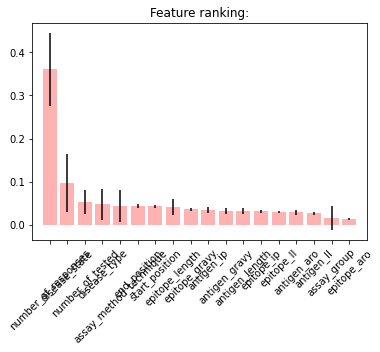

In [112]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("{}. feature {} ({:.3f})".format(f + 1, X.columns[indices][f], importances[indices[f]]))
    
plt.figure()
plt.title("Feature ranking:")
plt.bar(range(X.shape[1]), importances[indices],
        color='r', yerr=std[indices], align='center', alpha=0.3)
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

# LGBM opt

In [66]:
import numpy as np
import pandas as pd
import optuna
from lightgbm import LGBMClassifier
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from sklearn.metrics import f1_score

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [80]:
def objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "binary",
        "metric": "logloss",
        "eval_metric": "logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    model = LGBMClassifier(**params_lgb)
    model.fit(
        np.array(X_train),
        np.array(y_train),
        eval_set=[(np.array(X_train), np.array(y_train)), (np.array(X_val), np.array(y_val))],
        early_stopping_rounds=100,
        eval_metric = 'logloss',
        verbose=False,
    )

    lgb_pred = model.predict_proba(np.array(X_val))
    log_score = log_loss(np.array(y_val), lgb_pred)
    
    return log_score

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)

study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2022-07-21 15:08:53,318] A new study created in memory with name: lgbm_parameter_opt


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-07-21 15:09:17,381] Trial 0 finished with value: 0.04866980464870106 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 88, 'max_bin': 380}. Best is trial 0 with value: 0.04866980464870106.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-07-21 15:09:41,331] Trial 1 finished with value: 0.0486634394481373 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}. Best is trial 1 with value: 0.0486634394481373.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-07-21 15:09:56,813] Trial 2 finished with value: 0.04878900973272877 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_lambda': 0.02621062970553237, 'max_depth': 13, 'num_leaves': 37, 'colsample_bytree': 0.5752867891211308, 'subsample': 0.5564532903055841, 'subsample_freq': 5, 'min_child_samples': 80, 'max_bin': 260}. Best is trial 1 with value: 0.0486634394481373.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-07-21 15:10:29,671] Trial 3 finished with value: 0.09045670166997823 and parameters: {'reg_alpha': 1.5431890808024213e-05, 'reg_lambda': 0.05331731527343814, 'max_depth': 1, 'num_leaves': 156, 'colsample_bytree': 0.502314474212375, 'subsample': 0.3455361150896956, 'subsample_freq': 10, 'min_child_samples': 97, 'max_bin': 443}. Best is trial 1 with value: 0.0486634394481373.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-07-21 15:10:50,559] Trial 4 finished with value: 0.04770941560162321 and parameters: {'reg_alpha': 9.145366937509386e-06, 'reg_lambda': 0.008790499283853408, 'max_depth': 14, 'num_leaves': 114, 'colsample_bytree': 0.47322294090686734, 'subsample': 0.6466238370778892, 'subsample_freq': 1, 'min_child_samples': 92, 'max_bin': 277}. Best is trial 4 with value: 0.04770941560162321.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-07-21 15:11:12,660] Trial 5 finished with value: 0.04668549053612147 and parameters: {'reg_alpha': 1.987904330777592e-05, 'reg_lambda': 0.028054003730936226, 'max_depth': 11, 'num_leaves': 141, 'colsample_bytree': 0.5109126733153162, 'subsample': 0.9787092394351908, 'subsample_freq': 8, 'min_child_samples': 95, 'max_bin': 469}. Best is trial 5 with value: 0.04668549053612147.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-07-21 15:12:04,358] Trial 6 finished with value: 0.06096255736005441 and parameters: {'reg_alpha': 1.7941020364544445e-05, 'reg_lambda': 0.08296868193333816, 'max_depth': 2, 'num_leaves': 51, 'colsample_bytree': 0.4271363733463229, 'subsample': 0.527731231534285, 'subsample_freq': 4, 'min_child_samples': 31, 'max_bin': 449}. Best is trial 5 with value: 0.04668549053612147.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-07-21 15:12:22,282] Trial 7 finished with value: 0.0509861212662137 and parameters: {'reg_alpha': 1.0709032267540741e-05, 'reg_lambda': 0.025284113062519174, 'max_depth': 11, 'num_leaves': 37, 'colsample_bytree': 0.8813181884524238, 'subsample': 0.35218545057583955, 'subsample_freq': 10, 'min_child_samples': 79, 'max_bin': 259}. Best is trial 5 with value: 0.04668549053612147.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-07-21 15:12:42,825] Trial 8 finished with value: 0.04970556262652336 and parameters: {'reg_alpha': 1.7560829253683595e-07, 'reg_lambda': 0.07339153040632079, 'max_depth': 15, 'num_leaves': 187, 'colsample_bytree': 0.8627622080115674, 'subsample': 0.35183125621386324, 'subsample_freq': 4, 'min_child_samples': 16, 'max_bin': 459}. Best is trial 5 with value: 0.04668549053612147.


[LightGBM] [Warning] Unknown parameter: eval_metric


[I 2022-07-21 15:13:42,305] Trial 9 finished with value: 0.06092394114227073 and parameters: {'reg_alpha': 1.8702710823558463e-05, 'reg_lambda': 0.02978082892775818, 'max_depth': 2, 'num_leaves': 81, 'colsample_bytree': 0.5951099932160482, 'subsample': 0.8107243248366449, 'subsample_freq': 7, 'min_child_samples': 90, 'max_bin': 342}. Best is trial 5 with value: 0.04668549053612147.


Best Score: 0.04668549053612147
Best trial: {'reg_alpha': 1.987904330777592e-05, 'reg_lambda': 0.028054003730936226, 'max_depth': 11, 'num_leaves': 141, 'colsample_bytree': 0.5109126733153162, 'subsample': 0.9787092394351908, 'subsample_freq': 8, 'min_child_samples': 95, 'max_bin': 469}


In [93]:
model = LGBMClassifier(reg_alpha = 1.987904330777592e-05,
                       reg_lambda = 0.028054003730936226,
                       max_depth = 11,
                       num_leaves = 141,
                       colsample_bytree = 0.5109126733153162,
                       subsample = 0.9787092394351908,
                       subsample_freq = 8,
                       min_child_samples = 95,
                       max_bin = 469)
model.fit(
    np.array(X_train),
    np.array(y_train),
    eval_set=[(np.array(X_train), np.array(y_train)), (np.array(X_val), np.array(y_val))],
    early_stopping_rounds=100,
    eval_metric = 'logloss',
    verbose=False,
)

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score

def cal_mat(preds, labels):
    result = {}
    result['acc'] = accuracy_score(labels, preds)
    result['AUC'] = roc_auc_score(labels, preds)
    result['f1'] = f1_score(labels, preds, average='macro')
    result['precision'] = precision_score(labels, preds)
    result['recall'] = recall_score(labels, preds)
    result['bal_acc'] = balanced_accuracy_score(labels, preds)
    
    return result

preds = model.predict(np.array(X_val))
cal_mat(preds, y_val)

{'acc': 0.9793779315043366,
 'AUC': 0.9117889201247812,
 'f1': 0.9341475061232392,
 'precision': 0.9364613880742912,
 'recall': 0.829197922677438,
 'bal_acc': 0.9117889201247812}

In [94]:
preds1 = model.predict(np.array(X_test))

In [88]:
X.head()

,start_position,end_position,number_of_tested,number_of_responses,assay_method_technique,assay_group,disease_type,disease_state,epitope_length,antigen_length,epitope_ip,epitope_aro,epitope_gravy,epitope_II,antigen_ip,antigen_aro,antigen_gravy,antigen_II
0,3.00,8.00,nan,nan,4,1,4,4,6,113,8.75,0.00,-0.05,12.13,4.37,0.12,-0.14,12.78
1,7.00,12.00,nan,nan,4,1,4,4,6,113,5.55,0.00,-0.90,-19.97,4.37,0.12,-0.14,12.78
2,21.00,44.00,nan,nan,4,1,4,4,24,113,4.05,0.17,-0.45,32.05,4.37,0.12,-0.14,12.78
3,23.00,30.00,nan,nan,4,1,4,4,8,113,4.05,0.38,-0.93,89.00,4.37,0.12,-0.14,12.78
4,25.00,30.00,nan,nan,4,1,4,4,6,113,4.05,0.33,-1.57,94.77,4.37,0.12,-0.14,12.78


In [89]:
X_test.head()

,start_position,end_position,number_of_tested,number_of_responses,assay_method_technique,assay_group,disease_type,disease_state,epitope_length,antigen_length,epitope_ip,epitope_aro,epitope_gravy,epitope_II,antigen_ip,antigen_aro,antigen_gravy,antigen_II
0,2548.00,2563.00,20.00,1.00,1,1,1,1,16,7096,6.13,0.12,-0.91,68.86,6.32,0.11,-0.07,33.31
1,552.00,566.00,nan,nan,0,0,0,0,15,1256,4.05,0.07,0.59,71.49,6.99,0.07,-0.21,45.53
2,156.00,167.00,nan,nan,1,1,0,7,12,1345,8.75,0.08,-0.72,38.84,5.34,0.12,-0.12,33.63
3,1817.00,1828.00,nan,nan,1,1,1,1,12,7095,5.06,0.08,0.21,38.71,6.59,0.12,0.07,31.53
4,1211.00,1222.00,nan,nan,1,1,1,1,12,4382,4.05,0.00,-0.15,93.04,5.89,0.10,-0.02,36.10


In [95]:
model = LGBMClassifier(reg_alpha = 1.987904330777592e-05,
                       reg_lambda = 0.028054003730936226,
                       max_depth = 11,
                       num_leaves = 141,
                       colsample_bytree = 0.5109126733153162,
                       subsample = 0.9787092394351908,
                       subsample_freq = 8,
                       min_child_samples = 95,
                       max_bin = 469)
model.fit(
    np.array(X),
    np.array(y),
    eval_set=[(np.array(X), np.array(y))],
    early_stopping_rounds=100,
    eval_metric = 'logloss',
    verbose=False,
)

LGBMClassifier(colsample_bytree=0.5109126733153162, max_bin=469, max_depth=11,
               min_child_samples=95, num_leaves=141,
               reg_alpha=1.987904330777592e-05, reg_lambda=0.028054003730936226,
               subsample=0.9787092394351908, subsample_freq=8)

In [97]:
preds_all = model.predict(np.array(X_test))
submit = pd.read_csv('data/sample_submission.csv')
submit['label'] = preds_all
submit.to_csv('submission/lgbm_opt.csv', index=False)
print('Done.')

Done.


In [106]:
submit = pd.read_csv('data/sample_submission.csv')
submit['label'] = preds1
submit.to_csv('submission/lgbm_opt_0.8 split.csv', index=False)
print('Done.')

Done.
